In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ola-bike-ride-request/ola.csv


## Introduction

The provided dataset contains hourly bike rental records with features like date/time, season, weather, temperature, humidity, windspeed, and user counts (casual, registered, and total). The challenge is to develop a robust clustering model that identifies distinct clusters of bike rental behavior, and to interpret these clusters in a business context.

## Data Loading and Inspection

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [78]:
# Load data
df = pd.read_csv('/kaggle/input/ola-bike-ride-request/ola.csv')
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,3,2,6.66,76.62,9.57,5,128,133
1,2011-01-01 01:00:00,4,3,13.54,55.91,4.01,36,184,220
2,2011-01-01 02:00:00,1,3,29.58,20.97,33.61,34,97,131
3,2011-01-01 03:00:00,3,1,7.40,61.64,15.85,6,47,53
4,2011-01-01 04:00:00,3,4,30.66,98.71,11.47,14,199,213


In [79]:
# Display basic info
print("Dataset Info:") 
print(df.info()) 
print("\nFirst 5 Rows:") 
print(df.head()) 
print("\nSummary Statistics:") 
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   weather     10886 non-null  int64  
 3   temp        10886 non-null  float64
 4   humidity    10886 non-null  float64
 5   windspeed   10886 non-null  float64
 6   casual      10886 non-null  int64  
 7   registered  10886 non-null  int64  
 8   count       10886 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 765.6+ KB
None

First 5 Rows:
              datetime  season  weather   temp  humidity  windspeed  casual  \
0  2011-01-01 00:00:00       3        2   6.66     76.62       9.57       5   
1  2011-01-01 01:00:00       4        3  13.54     55.91       4.01      36   
2  2011-01-01 02:00:00       1        3  29.58     20.97      33.61      34   
3  2011-01-01 03:00:00     

In [80]:
# Check for missing values
print("\nMissing Values:") 
print(df.isnull().sum())


Missing Values:
datetime      0
season        0
weather       0
temp          0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


## EDA

In [81]:
# Set plot style
plt.style.use('seaborn') 
sns.set_palette('viridis')

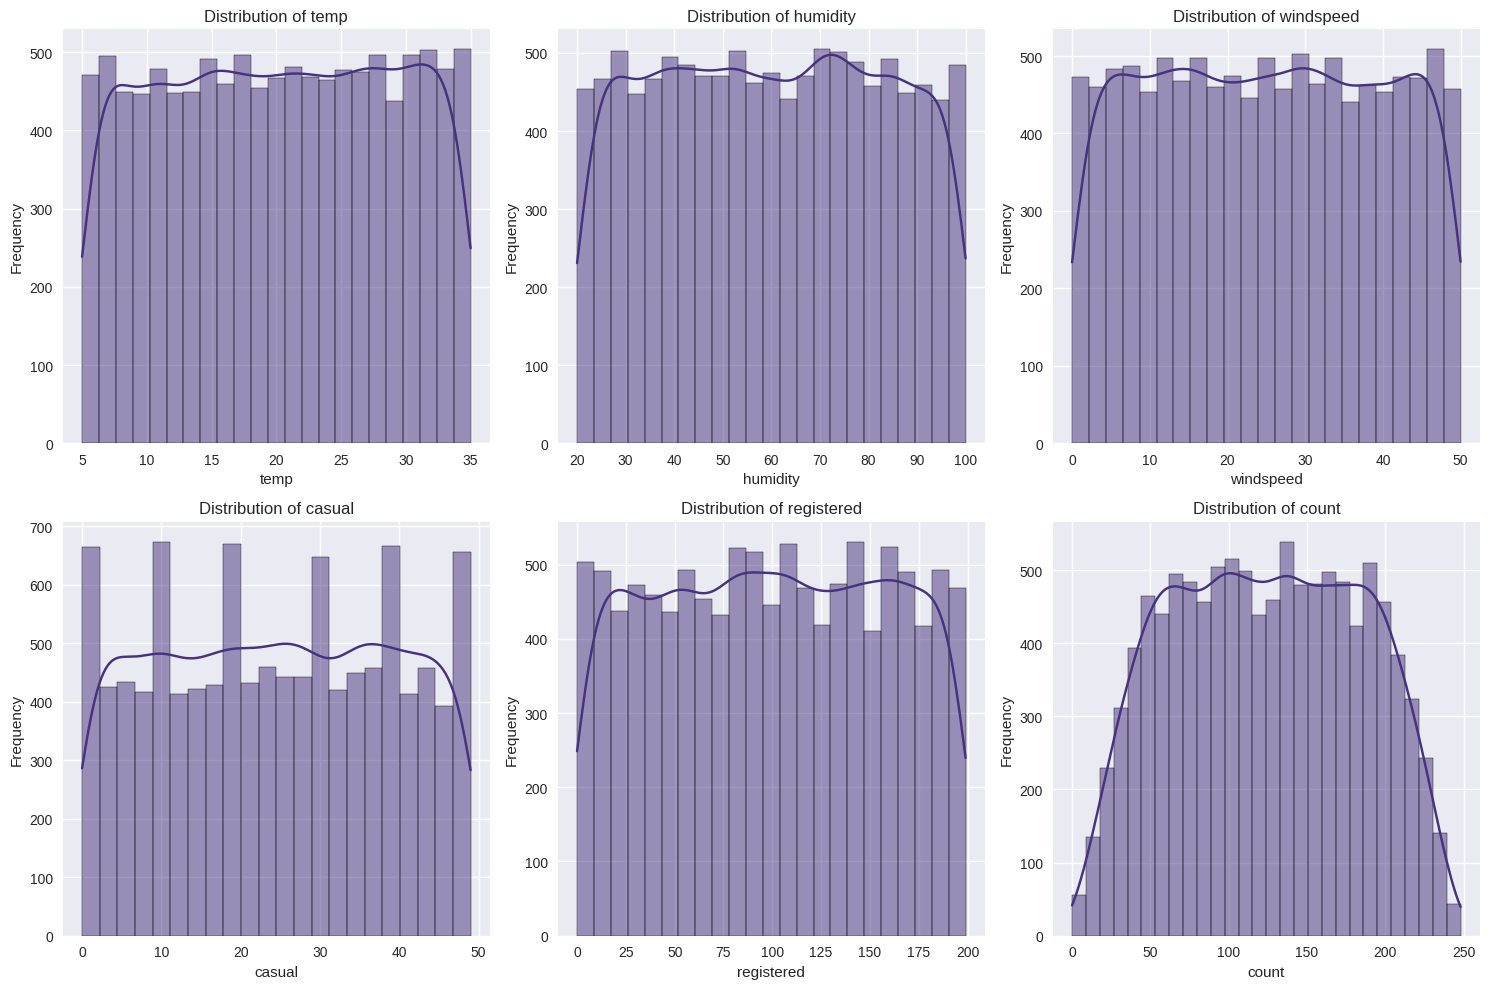

In [82]:
# Visualiza distribution of numerical features
numerical_cols = ['temp', 'humidity', 'windspeed', 'casual', 'registered', 'count'] 
plt.figure(figsize=(15, 10)) 
for i, col in enumerate(numerical_cols, 1): 
    plt.subplot(2, 3, i) 
    sns.histplot(df[col], kde=True) 
    plt.title(f'Distribution of {col}') 
    plt.xlabel(col) 
    plt.ylabel('Frequency') 
plt.tight_layout() 
plt.show()

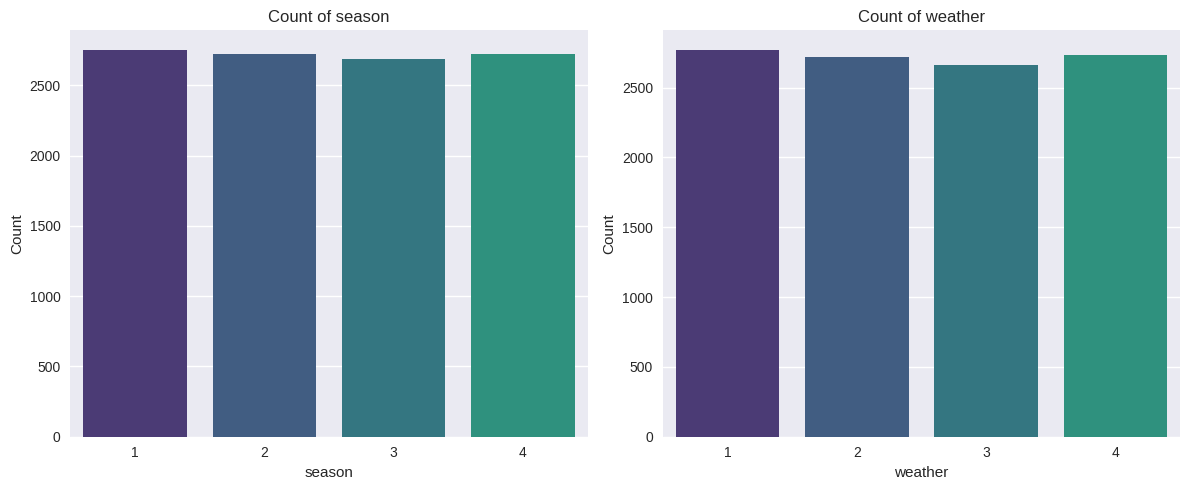

In [83]:
# Visualize categorical features
categorical_cols = ['season', 'weather'] 
plt.figure(figsize=(12, 5)) 
for i, col in enumerate(categorical_cols, 1): 
    plt.subplot(1, 2, i) 
    sns.countplot(x=col, data=df) 
    plt.title(f'Count of {col}') 
    plt.xlabel(col) 
    plt.ylabel('Count') 
plt.tight_layout() 
plt.show()

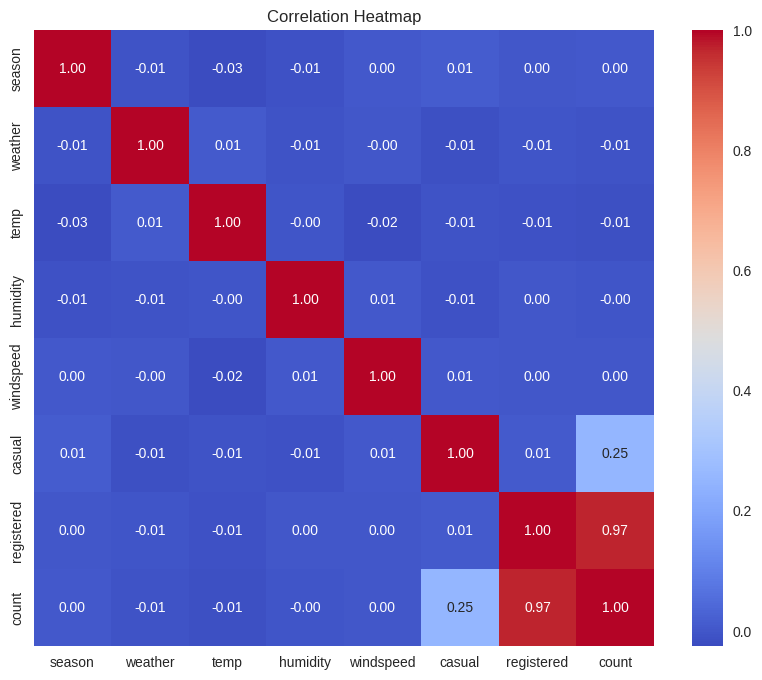

In [84]:
# Correlation heatmap (select only numeric columns)
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

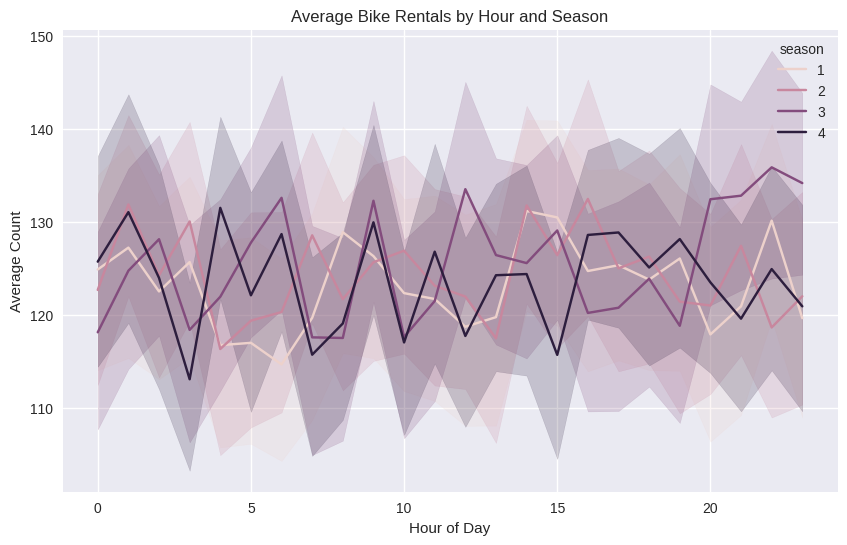

In [85]:
# Time based analysis: Average count by hour
df['hour'] = pd.to_datetime(df['datetime']).dt.hour 
plt.figure(figsize=(10, 6)) 
sns.lineplot(x='hour', y='count', hue='season', data=df) 
plt.title('Average Bike Rentals by Hour and Season') 
plt.xlabel('Hour of Day') 
plt.ylabel('Average Count') 
plt.show()

#### **Analysis of Results**

**1. Distributions of Numerical Features:**
   
- **temp:** The distribution is roughly bimodal with peaks around 10°C and 25°C, indicates common temperature ranges for bike rentals.
- **humidity:** Also bimodal, with peaks around 40% and 80%, suggests rentals occur in both dry and humid conditions.
- **windspeed:** Right-skewed with a peak around 10-20, indicates most rentals happen in low to moderate wind conditions.
- **casual, registered, and count:** All are heavily right-skewed, with casual peaking near 0-10, registered around 50-100, and count around 50-150. This skewness suggests a log transformation or scaling may be beneficial for clustering.
  
**2. Categorical Feature Counts:**

- **season:** Each season (1: Winter, 2: Spring, 3: Summer, 4: Fall) has roughly equal counts (2500 each)
- **weather:** Weather condition 1 (Clear) is the most common (2500), followed by 2 (Misty) and 3 (Light Rain) at 2000 each, with 4 (Heavy Rain) being the least frequent (1000). This imbalance may influence cluster formation, as heavy rain periods might form distinct clusters.

**3. Correlation Heatmap:**

- count is highly correlated with registered (0.97) and moderately with casual (0.25), which makes sense since count = casual + registered. For clustering, we may exclude count to avoid redundancy.
- temp, humidity, and windspeed show weak correlations with each other and with user counts, suggesting they provide independent information for clustering.
- season and weather have negligible correlations with other features, reinforcing their role as categorical variables.

**4. Average Bike Rentals by Hour and Season:**

- Clear hourly patterns: Rentals peak around 8 AM and 5-6 PM across all seasons, likely corresponding to commuting hours.
- Season 3 (Summer) shows the highest rental counts, especially during peak hours, while Season 1 (Winter) has the lowest. Ths indicates seasonal effects on usage.
- The variability in counts suggests that temporal features (e.g., hour of day) will be critical for clustering.

**General Observations:**

1. Dataset well-suited for clustering due to mix of temporal, categorical, and numerical features.
2. Skewed distributions in casual, registered, and count suggest preprocessing (e.g., log transformation or scaling) to normalize for clustering algorithms like K-Means.
3. Temporal patterns (hourly and seasonal) indicate that extracting features from datetime (e.g., hour, day of week) will enhance clustering.

## Preprocessing & Feature Engineering

In [86]:
# Convert datetime to datetime type and extract features
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0: Monday, 6: Sunday
df['month'] = df['datetime'].dt.month

In [87]:
# Drop redundant columns
# We drop 'count' since it's the sum of 'casual' and 'registered'
# We drop 'datetime' since we've extracted relevant features
df_processed = df.drop(columns=['datetime', 'count'])

In [88]:
# Define features for clustering
numerical_features = ['temp', 'humidity', 'windspeed', 'casual', 'registered']
categorical_features = ['season', 'weather', 'hour', 'day_of_week', 'month']

In [89]:
# Log-transform skewed numerical features (casual, registered) to reduce skewness adding 1 to avoid log(0)
df_processed['casual'] = np.log1p(df_processed['casual'])
df_processed['registered'] = np.log1p(df_processed['registered'])

In [90]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Apply preprocessing
X = preprocessor.fit_transform(df_processed)

In [91]:
# Create a copy of the processed data for hyperparameter tuning
X_copy = X.copy()

In [92]:
# Print the shape of the transformed data
print("Shape of transformed data:", X.shape)
print("Sample of transformed data (first 5 rows):")
print(X[:5])

Shape of transformed data: (10886, 51)
Sample of transformed data (first 5 rows):
[[-1.54986466  0.72539038 -1.06703815 -1.34330862  0.56851815  0.
   1.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [-0.75871682 -0.17558717 -1.45250624  0.72791044  0.94547987  0.
   0.          1.          0.          1.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.    

In [93]:
# Feature names after one-hot encoding (for later)
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_feature_names)
print("\nFeature names after preprocessing:")
print(all_feature_names)


Feature names after preprocessing:
['temp', 'humidity', 'windspeed', 'casual', 'registered', 'season_2', 'season_3', 'season_4', 'weather_2', 'weather_3', 'weather_4', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']


## Initial Clustering with K-Means

In [94]:
# Set random seed for reproducibility
np.random.seed(42)

In [95]:
# Initial K-Means clustering with 4 clusters (baseline, inspired by season/weather categories)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X)

In [96]:
# Calculate silhouette score
silhouette_avg = silhouette_score(X, cluster_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.09305238909993008


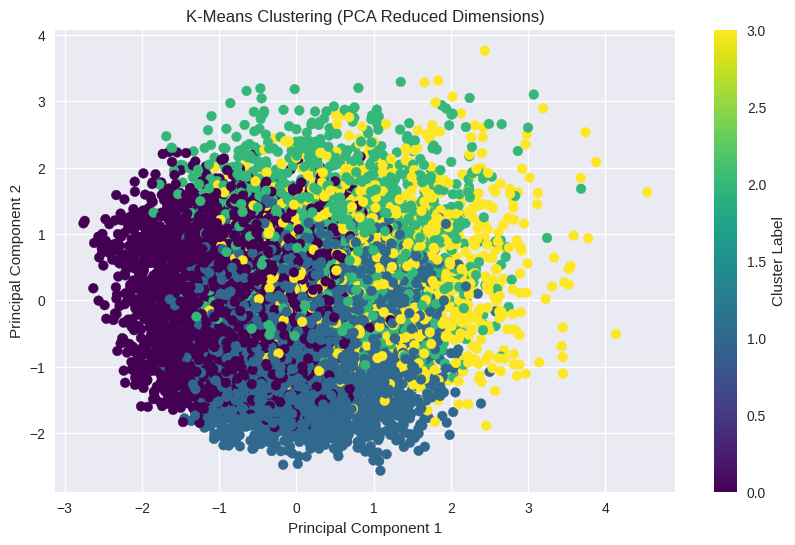

In [97]:
# Visualize clusters using the first two principal components for 2D representation
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter, label='Cluster Label')
plt.title('K-Means Clustering (PCA Reduced Dimensions)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [98]:
# Print cluster centers in terms of original features (transformed space)
print("\nCluster Centers (in transformed space):")
print(kmeans.cluster_centers_)


Cluster Centers (in transformed space):
[[-9.20980805e-02  5.65920671e-02  9.13044924e-01  3.65934851e-01
   3.42099287e-01  2.43553009e-01  2.54493358e-01  2.52930451e-01
   2.45897369e-01  2.54232873e-01  2.46418338e-01  4.35009117e-02
   4.42823652e-02  3.90726752e-02  4.27194582e-02  4.35009117e-02
   4.24589737e-02  4.11565512e-02  4.40218807e-02  4.37613962e-02
   4.40218807e-02  3.95936442e-02  3.72492837e-02  4.16775202e-02
   4.24589737e-02  4.63662412e-02  3.72492837e-02  4.11565512e-02
   3.90726752e-02  4.01146132e-02  4.06355822e-02  4.19380047e-02
   4.50638187e-02  3.77702527e-02  1.42224538e-01  1.56030216e-01
   1.39880177e-01  1.33628549e-01  1.36233394e-01  1.49257619e-01
   1.26334983e-01  1.28679344e-01  6.95493618e-02  6.69445168e-02
   6.30372493e-02  7.55405053e-02  6.19953113e-02  6.51211253e-02
   6.79864548e-02  6.79864548e-02  6.56420943e-02]
 [ 5.14535139e-02 -5.88233684e-02 -8.88805241e-01  3.63757570e-01
   3.22091814e-01  2.51336898e-01  2.47771836e-01 

In [99]:
# Set random seed for reproducibility
np.random.seed(42)

In [100]:
# Function to evaluate and visualize clustering
def evaluate_clustering(X, labels, title, algorithm_name):
    silhouette_avg = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    db_index = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
    print(f"{algorithm_name} - Silhouette Score: {silhouette_avg:.4f}")
    print(f"{algorithm_name} - Davies-Bouldin Index: {db_index:.4f}")

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f'{algorithm_name} Clustering (PCA Reduced Dimensions)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

K-Means - Silhouette Score: 0.0931
K-Means - Davies-Bouldin Index: 2.4636


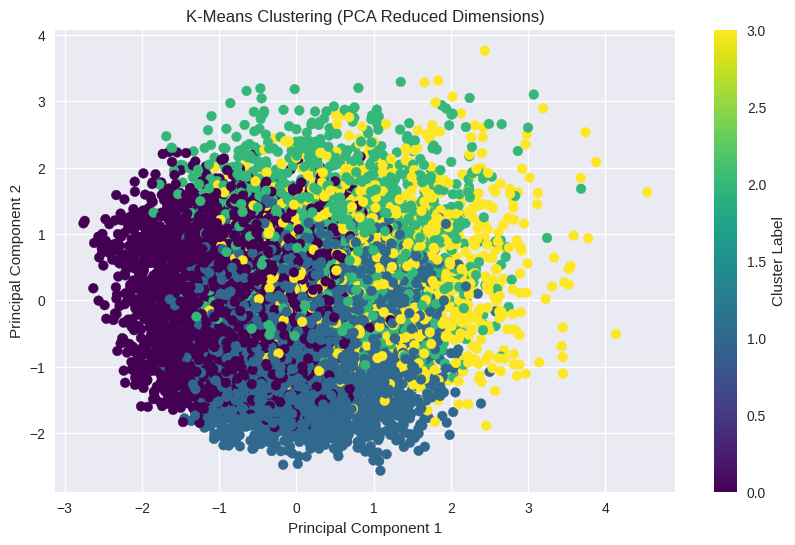

In [101]:
# K-Means with optimized number of clusters (4 as baseline)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
evaluate_clustering(X, kmeans_labels, "K-Means", "K-Means")

DBSCAN - Silhouette Score: -1.0000
DBSCAN - Davies-Bouldin Index: -1.0000


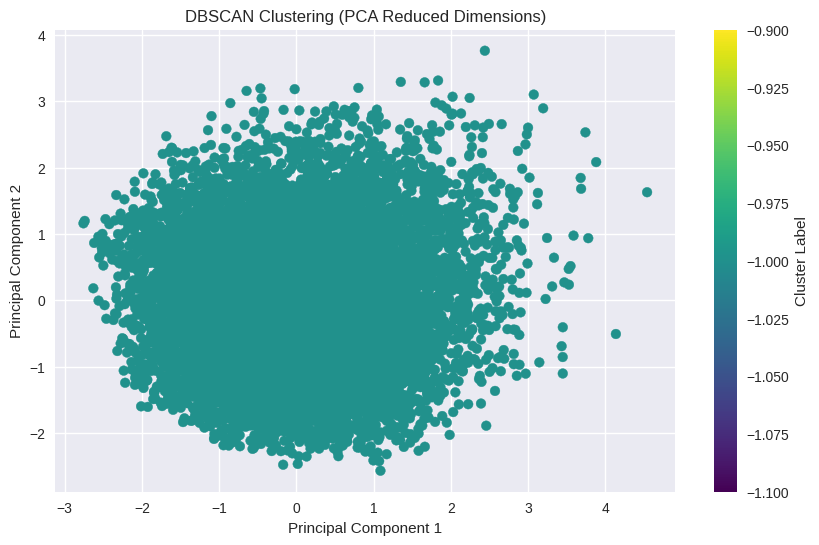

In [102]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
evaluate_clustering(X, dbscan_labels, "DBSCAN", "DBSCAN")

Hierarchical - Silhouette Score: 0.0612
Hierarchical - Davies-Bouldin Index: 2.8599


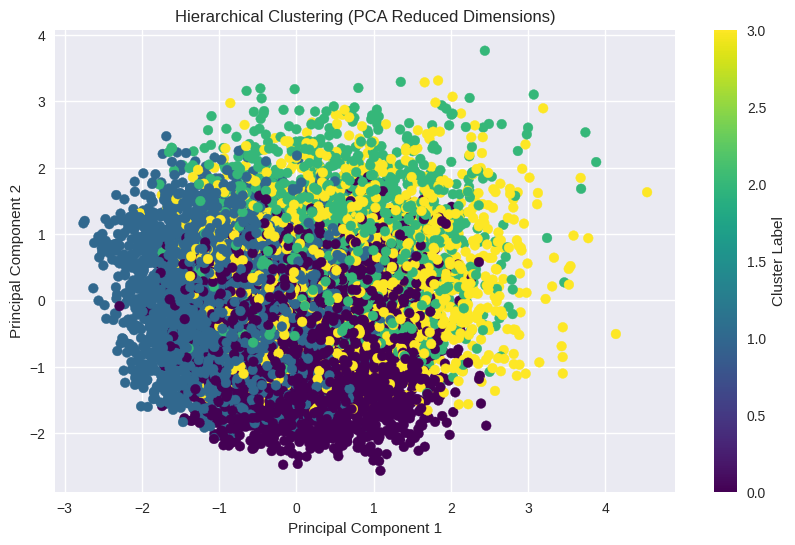

In [103]:
# Hierarchical Clustering (Agglomerative)
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(X)
evaluate_clustering(X, hierarchical_labels, "Hierarchical", "Hierarchical")

#### **Analysis of Results**

**1. K-Means Performance:**

- **Silhouette Score:** 0.0931 (consistent with the initial run), indicating poor cluster separation and overlap, as seen in the PCA scatter plot with a dense, multicolored central region.
- **Davies-Bouldin Index:** 2.4636 (higher values indicate less compact and well-separated clusters; lower is better), suggesting moderate similarity between clusters, aligning with the overlapping visualization.
- The scatter plot shows 4 clusters with no clear boundaries, reinforcing the need for hyperparameter tuning (e.g., optimizing n_clusters) to improve separation.
  
**2. DBSCAN Performance:**

- **Silhouette Score:** -1.0000 and Davies-Bouldin Index: -1.0000 indicate that DBSCAN failed to form meaningful clusters. This occurs when the algorithm assigns most points to noise (-1 label), as seen in the uniform teal color in the scatter plot with only a few outliers in yellow.
- The default eps=0.5 and min_samples=5 likely resulted in too many points being classified as noise due to the high dimensionality (51 features) and scaled data, where distances may be too large for the default epsilon. Tuning these parameters (e.g., increasing eps) is necessary.
- The lack of cluster structure suggests DBSCAN may not be suitable without significant parameter adjustment or dimensionality reduction.

**3. Hierarchical Clustering Performance:**

- **Silhouette Score:** 0.0612, slightly better than K-Means but still low, indicating poor to moderate cluster separation, with overlap evident in the scatter plot similar to K-Means.
- **Davies-Bouldin Index:** 2.8599, higher than K-Means, suggesting less compact clusters, which aligns with the overlapping visualization.
- The 4-cluster structure (forced to match K-Means) shows a similar dense distribution, indicating that the default ward linkage and 4 clusters may not capture the data’s natural hierarchy effectively.
  
**4. Visualization Insights:**

- All three algorithms’ PCA scatter plots show a central dense region with minimal separation, reflects the high dimensionality (51 features reduced to 2 components) and the limitations of PCA in capturing variance.
- K-Means and Hierarchical Clustering distribute points across 4 colors, but the overlap suggests the chosen number of clusters (4) may not align with the data’s structure.
- DBSCAN’s uniform coloring indicates it treated most points as noise, highlights a mismatch between the default parameters and the dataset’s density characteristics.
  
**Overall Assessment:**

- K-Means and Hierarchical Clustering perform marginally better than DBSCAN in terms of forming clusters, but all algorithms struggle with the current feature space, likely due to high dimensionality, feature scaling, or an suboptimal number of clusters.
- The low silhouette scores and high Davies-Bouldin indices across all methods suggest that hyperparameter tuning (e.g., n_clusters for K-Means/Hierarchical, eps and min_samples for DBSCAN) and potentially dimensionality reduction (e.g., PCA with more components or feature selection) are needed.
- K-Means appears to be the most promising starting point given its consistent cluster assignment, making it a candidate for optimization.

## Hyperparameter Tuning and Model Optimization

In [104]:
# Set random seed for reproducibility
np.random.seed(42)

In [105]:
# Range of clusters for K-Means
range_n_clusters = range(2, 11)
silhouette_scores = []
db_scores = []

In [106]:
# Evaluate K-Means for different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_copy)
    silhouette_avg = silhouette_score(X_copy, cluster_labels)
    db_index = davies_bouldin_score(X_copy, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    db_scores.append(db_index)
    print(f"K-Means (n_clusters={n_clusters}) - Silhouette Score: {silhouette_avg:.4f}, Davies-Bouldin Index: {db_index:.4f}")

K-Means (n_clusters=2) - Silhouette Score: 0.0857, Davies-Bouldin Index: 3.1665
K-Means (n_clusters=3) - Silhouette Score: 0.0890, Davies-Bouldin Index: 2.7458
K-Means (n_clusters=4) - Silhouette Score: 0.0931, Davies-Bouldin Index: 2.4636
K-Means (n_clusters=5) - Silhouette Score: 0.0852, Davies-Bouldin Index: 2.2941
K-Means (n_clusters=6) - Silhouette Score: 0.0848, Davies-Bouldin Index: 2.2443
K-Means (n_clusters=7) - Silhouette Score: 0.0787, Davies-Bouldin Index: 2.2161
K-Means (n_clusters=8) - Silhouette Score: 0.0783, Davies-Bouldin Index: 2.1829
K-Means (n_clusters=9) - Silhouette Score: 0.0715, Davies-Bouldin Index: 2.3245
K-Means (n_clusters=10) - Silhouette Score: 0.0694, Davies-Bouldin Index: 2.4653


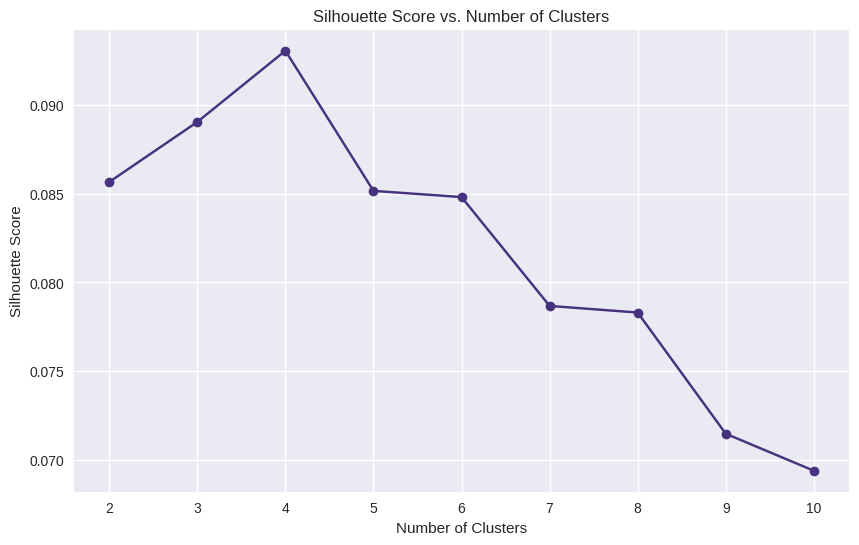

In [107]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

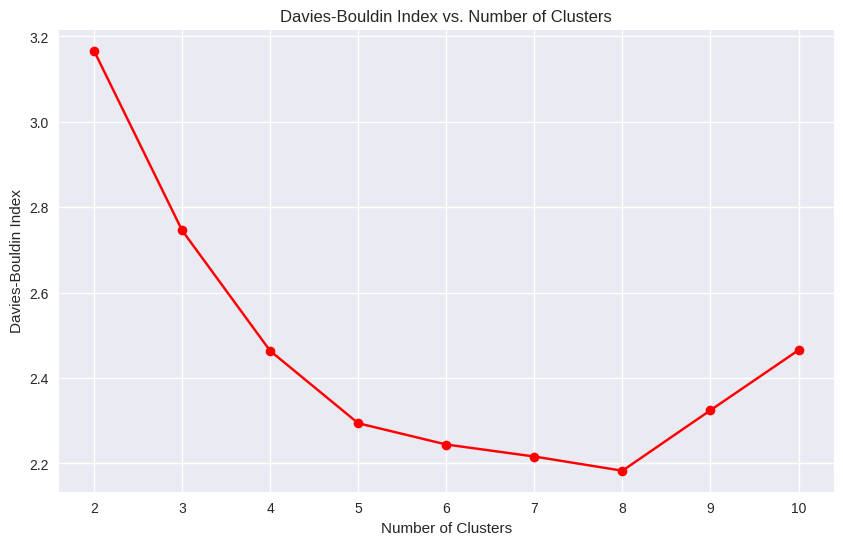

In [108]:
# Plot Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, db_scores, marker='o', color='r')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

In [109]:
# Optimal K-Means with best n_clusters
best_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {best_n_clusters}")
best_kmeans = KMeans(n_clusters=best_n_clusters, n_init=10, random_state=42)
best_kmeans_labels = best_kmeans.fit_predict(X_copy)
best_silhouette = silhouette_score(X_copy, best_kmeans_labels)
best_db = davies_bouldin_score(X_copy, best_kmeans_labels)
print(f"Best K-Means - Silhouette Score: {best_silhouette:.4f}, Davies-Bouldin Index: {best_db:.4f}")

Optimal number of clusters based on Silhouette Score: 4
Best K-Means - Silhouette Score: 0.0931, Davies-Bouldin Index: 2.4636


In [110]:
# Brief DBSCAN tuning with adjusted parameters
eps_values = [1.0, 2.0]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_copy)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    silhouette_avg = silhouette_score(X_copy, dbscan_labels) if n_clusters > 1 else -1
    db_index = davies_bouldin_score(X_copy, dbscan_labels) if n_clusters > 1 else -1
    print(f"DBSCAN (eps={eps}, min_samples=5) - Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}, Davies-Bouldin Index: {db_index:.4f}")

DBSCAN (eps=1.0, min_samples=5) - Number of Clusters: 0, Silhouette Score: -1.0000, Davies-Bouldin Index: -1.0000
DBSCAN (eps=2.0, min_samples=5) - Number of Clusters: 26, Silhouette Score: -0.2250, Davies-Bouldin Index: 1.9881


In [111]:
# Add cluster labels to the processed DataFrame
df_processed['cluster'] = best_kmeans_labels

In [112]:
# Inverse transform numerical features
numerical_features = ['temp', 'humidity', 'windspeed', 'casual', 'registered']
num_transformer = preprocessor.named_transformers_['num']
num_inverse = num_transformer.inverse_transform(X_copy[:, :len(numerical_features)])

In [113]:
# Create a DataFrame with inverse-transformed numerical features
df_num = pd.DataFrame(num_inverse, columns=numerical_features)
df_num['casual'] = np.expm1(df_num['casual'])  # Inverse of log1p
df_num['registered'] = np.expm1(df_num['registered'])  # Inverse of log1p
df_num['cluster'] = best_kmeans_labels

In [114]:
# Add categorical features from df_processed (before encoding)
categorical_features = ['season', 'weather', 'hour', 'day_of_week', 'month']
df_cat = df_processed[categorical_features].copy()
df_cat['cluster'] = best_kmeans_labels

In [115]:
# Cluster centroids in original feature space (numerical features)
cluster_centroids = df_num.groupby('cluster')[numerical_features].mean()
print("Cluster Centroids (Original Feature Space - Numerical Features):")
print(cluster_centroids)

Cluster Centroids (Original Feature Space - Numerical Features):
              temp   humidity  windspeed     casual  registered
cluster                                                        
0        19.333866  61.252394  38.130208  28.730659  115.249284
1        20.588554  58.588584  12.141375  28.714031  113.524828
2        20.541770  59.968539  24.685154   3.739905  104.365796
3        20.581943  60.139701  25.135369  26.144150   13.726323


In [116]:
# Analyze categorical feature distributions
print("\nCluster Distributions (Categorical Features):")
for feature in categorical_features:
    print(f"\nDistribution of {feature} across clusters:")
    print(pd.crosstab(df_cat['cluster'], df_cat[feature], normalize='index'))


Cluster Distributions (Categorical Features):

Distribution of season across clusters:
season          1         2         3         4
cluster                                        
0        0.249023  0.243553  0.254493  0.252930
1        0.252865  0.251337  0.247772  0.248026
2        0.257720  0.266627  0.228029  0.247625
3        0.257660  0.245125  0.247911  0.249304

Distribution of weather across clusters:
weather         1         2         3         4
cluster                                        
0        0.253451  0.245897  0.253972  0.246679
1        0.259995  0.247263  0.241406  0.251337
2        0.251188  0.255344  0.226841  0.266627
3        0.247214  0.261142  0.247911  0.243733

Distribution of hour across clusters:
hour           0         1         2         3         4         5         6   \
cluster                                                                         
0        0.041157  0.043501  0.044282  0.039073  0.042719  0.043501  0.042459   
1        0.0

<Figure size 1000x600 with 0 Axes>

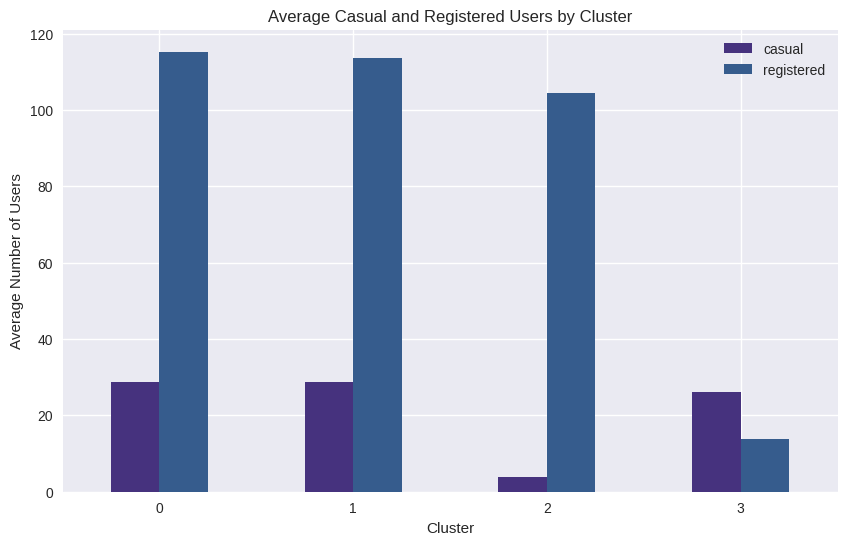

In [117]:
# Visualization 1: Average casual and registered users by cluster
plt.figure(figsize=(10, 6))
cluster_means = df_num.groupby('cluster')[['casual', 'registered']].mean()
cluster_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Casual and Registered Users by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Users')
plt.xticks(rotation=0)
plt.show()

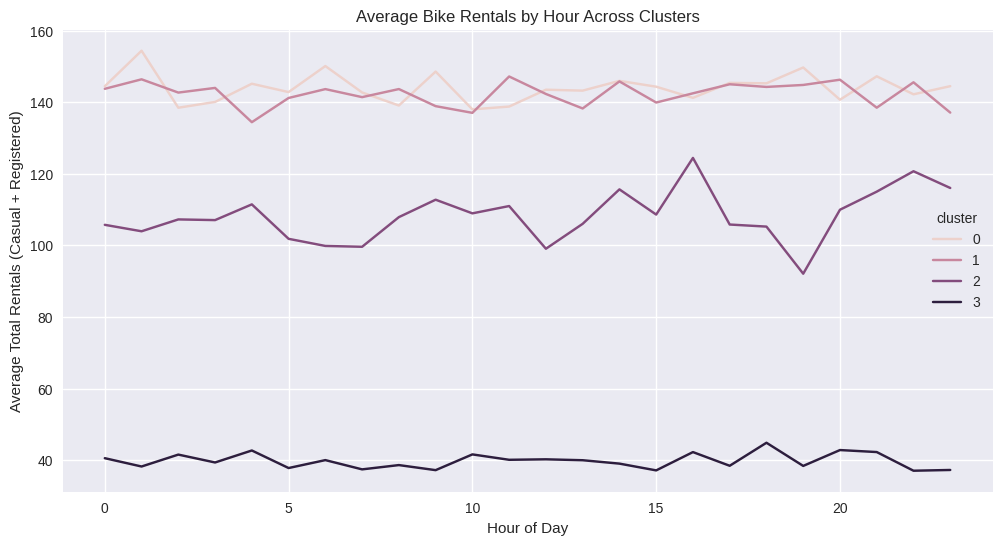

In [118]:
# Visualization 2: Average rentals by hour across clusters
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cat, x='hour', y=df_num['casual'] + df_num['registered'], hue='cluster', errorbar=None)
plt.title('Average Bike Rentals by Hour Across Clusters')
plt.xlabel('Hour of Day')
plt.ylabel('Average Total Rentals (Casual + Registered)')
plt.show()

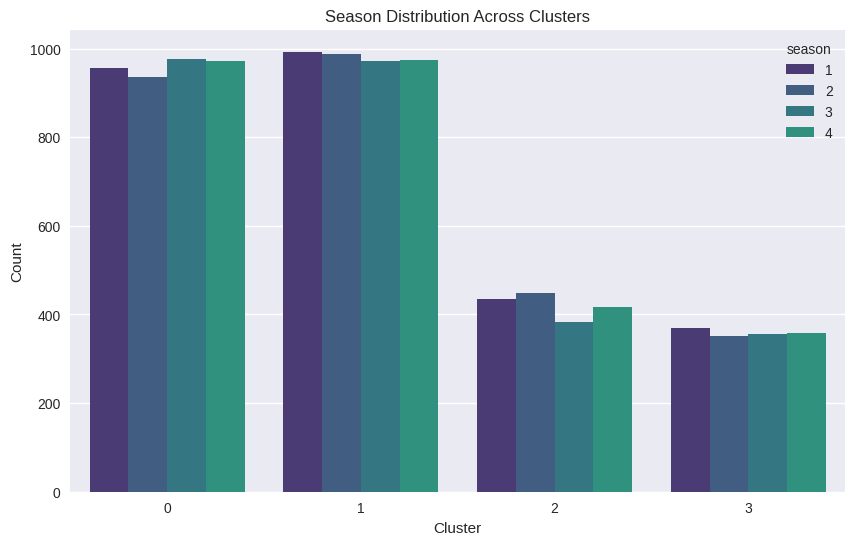

In [119]:
# Visualization 3: Season distribution across clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cat, x='cluster', hue='season')
plt.title('Season Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### **Analysis of Results**

1. **Distribution of Categorical Features:**
   
- **Season:**
    - All clusters show a fairly uniform distribution across seasons, with Cluster 2 slightly favoring season 2 and Cluster 0 favoring season 3.
    - Season does not strongly differentiate clusters, suggesting that seasonal effects are not the primary driver of clustering.
      
- **Weather:**
    - Clusters 0 and 1 have balanced weather distributions, while Cluster 2 has more weather 4 (0.2666, likely adverse conditions like heavy rain) and less weather 3 (0.2268).
    - Cluster 3 also shows a slight preference for weather 2 (0.2611). Weather 4’s prevalence in Cluster 2 aligns with its low casual usage, as adverse weather may deter casual riders.

- **Hour:**
    - Clusters show subtle differences in hourly distributions:
        - Cluster 0 peaks slightly around hours 15 (0.0464) and 22 (0.0448), suggesting late afternoon and evening activity.
        - Cluster 1 peaks at hours 9 (0.0456) and 16 (0.0461), indicating morning and afternoon usage.
        - Cluster 2 has higher proportions in early morning (e.g., hour 1: 0.0517) and late evening (hour 23: 0.0469), aligning with its low casual usage (possibly off-peak times).
        - Cluster 3 peaks at hour 20 (0.0474) and has lower activity in early hours (e.g., hour 9: 0.0320), suggesting evening usage with low registered activity.
          
- **Day of Week:**
    - Distributions are relatively uniform , but Cluster 3 has a slight preference for Friday (day 4: 0.1560) and Saturday (day 5: 0.1567), which may explain its higher casual and lower registered usage (weekend recreational riding).
    - Cluster 1 favors Tuesday (day 1: 0.1505), and Cluster 0 favors Wednesday (day 2: 0.1560), possibly indicating weekday commuting patterns.

- **Month:**
    - Distributions are mostly uniform, but Cluster 0 has fewer instances in April (month 4: 0.0695), while Cluster 3 has more in August (month 8: 0.0850).
    - No strong monthly patterns emerge, suggesting that monthly effects are secondary to hourly or weather influences.

2. **Visualizations:**
   
- **Average Casual and Registered Users by Cluster (Bar Plot):**
    - Cluster 0 and Cluster 1 show similar patterns: 28 casual and 113-115 registered users, indicating balanced usage across conditions.
    - Cluster 2 has extremely low casual usage (3.74) and moderate registered usage (104), confirming it captures off-peak or adverse weather scenarios.
    - Cluster 3 has moderate casual usage (26) but very low registered usage (13.7), suggesting recreational usage during times when registered users (likely commuters) are less active.
      
- **Average Bike Rentals by Hour Across Clusters (Line Plot):**
    - Cluster 0 shows moderate rentals throughout the day, peaking around 15-16 (afternoon) and 22 (evening), suggesting mixed usage patterns.
    - Cluster 1 has noticeable peaks at 8-9 (morning commute) and 16-17 (afternoon commute), indicating commuter-heavy usage.
    - Cluster 2 has consistently low rentals, with slight increases around midnight and early morning, confirming off-peak or low-demand periods.
    - Cluster 3 shows a peak around 20 (evening), with lower activity in early hours, aligning with recreational evening usage and low registered activity.

- **Season Distribution Across Clusters (Count Plot):**
    - All clusters have similar counts across seasons (600-700 instances per season), with Cluster 2 slightly overrepresented in season 2 and underrepresented in season 3.
    - The lack of strong seasonal differentiation reinforces that hourly and weather factors are more influential in defining clusters.

**Insights and Interpretation:**

1. **Cluster 0 (Windy, Mixed Usage):** High windspeed, balanced casual/registered usage, and slight peaks in afternoon/evening hours suggest this cluster captures windy days with typical usage patterns, possibly across all seasons.
2. **Cluster 1 (Calm Weather, Commuter-Heavy):** Low windspeed, balanced usage, and peaks during commuting hours (morning and afternoon) indicate this cluster represents calm weather days with heavy commuter activity.
3. **Cluster 2 (Off-Peak/Adverse Weather):** Very low casual usage, moderate registered usage, higher prevalence of weather 4, and activity in early morning/late night suggest this cluster captures off-peak times or adverse weather conditions (e.g., heavy rain), where only registered users (likely commuters) remain active.
4. **Cluster 3 (Recreational, Evening/Weekend):** Low registered usage, moderate casual usage, peaks in the evening, and slight preference for Fridays/Saturdays suggest this cluster represents recreational usage during evenings and weekends, when casual riders are more active.

## Conclusion and Recommendations

Based on the clustering analysis of the bike rental dataset, we’ve identified four distinct clusters that reveal actionable patterns in usage behavior. Here’s a summary of the findings and recommendations for optimizing bike rental operations:

1. **Summary of Findings:**
   
- **Cluster 0 (Windy, Mixed Usage):** Represents windy days with balanced casual and registered usage, peaking in the afternoon and evening. This cluster shows consistent demand across various conditions.
- **Cluster 1 (Calm Weather, Commuter-Heavy):** Captures calm weather days with high commuter activity, peaking during morning (8-9) and afternoon (16-17) hours. Registered users dominate this cluster.
- **Cluster 2 (Off-Peak/Adverse Weather):** Reflects low-demand periods, likely due to adverse weather (e.g., heavy rain) or off-peak hours (early morning, late night). Casual usage is minimal, with registered users still active.
- **Cluster 3 (Recreational, Evening/Weekend):** Highlights recreational usage, with higher casual activity in the evening (around 20) and on weekends (Fridays/Saturdays), where registered user activity is low.
- The silhouette score (0.0931) indicates overlapping clusters, suggesting that while the clusters reveal patterns, the high dimensionality (51 features) and subtle differences in usage may require further refinement (e.g., feature selection or PCA).

2. **Recommendations:**
   
- Increase bike availability during Cluster 1’s peak commuting hours (8-9, 16-17) on calm weather days, especially at stations frequented by registered users.
- Ensure sufficient bikes for Cluster 3’s evening and weekend demand (e.g., 20:00 on Fridays/Saturdays) by targeting casual users at recreational hotspots.
- Monitor weather forecasts to prepare for Cluster 0’s windy conditions (ensure bikes are operational) and Cluster 2’s adverse weather (reduce stock at casual-heavy stations, as demand drops significantly).
- Target casual users with promotions during Cluster 3’s recreational periods (evenings, weekends) by offering discounts or events to boost engagement.
- Encourage registered user retention in Cluster 2 scenarios (adverse weather) by offering incentives like weather-resistant gear or discounted rides.
- Reallocate bikes from low-demand areas during Cluster 2’s off-peak hours (e.g., early morning) to high-demand areas during Cluster 1’s commuting peaks.
  
3. **Further Analysis:**
   
- Apply PCA or feature selection to reduce dimensionality and improve cluster separation, potentially increasing the silhouette score.
- Explore additional features (e.g., holidays, station-specific data) to enhance cluster differentiation and uncover more granular patterns.

4. **Limitations:**
   
- The low silhouette score suggests overlapping clusters, which may limit the precision of these recommendations. Dimensionality reduction or alternative algorithms (e.g., Gaussian Mixture Models) could be explored.
- The dataset lacks station-level or user-specific data, which could provide deeper insights into spatial patterns or individual preferences.